In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries - PyTorch

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import time

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.models import resnet101, resnet50, resnet18
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torchvision.datasets import CIFAR100 
from torchvision import datasets, models, transforms
from torchinfo import summary

from tqdm import tqdm

In [2]:
torch.manual_seed(0)

In [ ]:
!rm -rf /kaggle/working/*

In [ ]:
!rm -rf /kaggle/working/models/*

In [3]:
os.makedirs("/kaggle/working/models",exist_ok=True)

In [4]:
os.makedirs("/kaggle/working/aftermodels",exist_ok=True)

# Compute stats

In [ ]:
stat_train_data = CIFAR100(download=True, root="./data", transform=tt.ToTensor())
stat_test_data = CIFAR100(root="./data", train=False, transform=tt.ToTensor())

In [ ]:
imgs_train = torch.stack([img_t for img_t ,_ in stat_train_data],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in stat_test_data],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

# Stat and transform

In [5]:
stats=((0.50736207, 0.4866896, 0.44108862), (0.26748815, 0.2565931, 0.2763085))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# 100 classes

In [6]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

100%|██████████| 169001437/169001437 [00:04<00:00, 35089916.52it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [7]:
batch_size=128
num_work=4
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

# 20 classes

In [8]:
class CIFAR100Coarse(torch.utils.data.Dataset):
    def __init__(self, cifar100_dataset) ->None:
        self.cifar100_dataset = cifar100_dataset
        
        # Define the mapping from fine labels to coarse labels
        self.fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }
        
        # Mapping from superclass labels to superclass names
        self.coarse_label_names = {
            0: 'aquatic mammals',
            1: 'fish',
            2: 'flowers',
            3: 'food containers',
            4: 'fruit and vegetables',
            5: 'household electrical devices',
            6: 'household furniture',
            7: 'insects',
            8: 'large carnivores',
            9: 'large man-made outdoor things',
            10: 'large natural outdoor scenes',
            11: 'large omnivores and herbivores',
            12: 'medium-sized mammals',
            13: 'non-insect invertebrates',
            14: 'people',
            15: 'reptiles',
            16: 'small mammals',
            17: 'trees',
            18: 'vehicles 1',
            19: 'vehicles 2'
        }

    def __getitem__(self, index):
        img, target = self.cifar100_dataset[index]

        # Convert fine label to coarse label
        target_coarse = self.fine_to_coarse[target]

        return img, target, target_coarse

    def __len__(self):
        return len(self.cifar100_dataset)

    def get_coarse_label_name(self, label):
        return self.coarse_label_names[label]

    def get_all_coarse_label_names(self):
        return self.coarse_label_names.values()


In [9]:
train_data_20=CIFAR100Coarse(train_data)
test_data_20=CIFAR100Coarse(test_data)

In [10]:
batch_size=128
num_work=4
train_dl_20 = DataLoader(train_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl_20 = DataLoader(test_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

## Print number of items for each superclass

In [ ]:
train_classes_20={}

for img,label in train_data_20:
    class_name=train_data_20.coarse_label_names[label]
    if class_name not in train_classes_20:
        train_classes_20[class_name]=1
    else:
        train_classes_20[class_name]+=1

In [ ]:
train_classes_20

# Device - GPU cuda

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [12]:
class DoubleResNet18(nn.Module):
    def __init__(self, leaf_classes=100, superclasses=20):
        super(DoubleResNet18, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.resnet.maxpool=nn.Identity()
        num_ftrs = self.resnet.fc.in_features #512 ;)
        self.fc1 = nn.Linear(num_ftrs, leaf_classes)
        self.fc2 = nn.Linear(num_ftrs, superclasses)
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1) # to sprawdzić czy potrzeba!!!!!
        
        logits1 = self.fc1(x) # to będzie na 100 class oczywiście
        
        logits2 = self.fc2(x) #superklasy
        
        return logits1, logits2

In [99]:
model=DoubleResNet18()

In [100]:
model=model.to(device)

In [22]:
summary(model,(128,3,32,32))

Layer (type:depth-idx)                        Output Shape              Param #
DoubleResNet18                                [128, 100]                --
├─ResNet: 1-1                                 --                        513,000
│    └─Conv2d: 2-1                            [128, 64, 32, 32]         1,728
│    └─BatchNorm2d: 2-2                       [128, 64, 32, 32]         128
│    └─ReLU: 2-3                              [128, 64, 32, 32]         --
│    └─Identity: 2-4                          [128, 64, 32, 32]         --
│    └─Sequential: 2-5                        [128, 64, 32, 32]         --
│    │    └─BasicBlock: 3-1                   [128, 64, 32, 32]         73,984
│    │    └─BasicBlock: 3-2                   [128, 64, 32, 32]         73,984
│    └─Sequential: 2-6                        [128, 128, 16, 16]        --
│    │    └─BasicBlock: 3-3                   [128, 128, 16, 16]        230,144
│    │    └─BasicBlock: 3-4                   [128, 128, 16, 16]        2

# Optimizer, scheduler, criterion

In [101]:
# For optimizer:
max_lr=5e-2
momentum=0.9
weight_decay = 5e-4
criterion_I = nn.CrossEntropyLoss()
criterion_II = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,55,60,80,120,140], gamma=0.1)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,80,120,140], gamma=0.2)

In [102]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True,factor=0.1)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)

# Training and validation loop

In [82]:
num_epochs=300

In [ ]:
os.makedirs('/kaggle/working/models/')

In [103]:
!rm -rf /kaggle/working/models/*

# Train for 20 classes

In [ ]:
train_loss=[]
train_loss_I=[]
train_loss_II=[]
train_acc=[]
train_acc_coarse=[]
test_loss=[]
test_loss_I=[]
test_loss_II=[]
test_acc=[]
test_acc_coarse=[]
alpha=0.9
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    correct_predictions_coarse=0
    total_samples = 0
    total_samples_coarse=0
    total_loss_I=0.0
    total_loss_II=0.0

    data_loader = tqdm(train_dl_20, total=len(train_dl_20), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets, targets_coarse) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets, targets_coarse = inputs.to(device), targets.to(device), targets_coarse.to(device)


        logits1, logits2 = model(inputs)
        loss_I = criterion_I(logits1, targets)
        loss_II=criterion_II(logits2, targets_coarse)
        loss=(alpha)*loss_I+(1-alpha)*loss_II
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_I += loss_I.item()
        total_loss_II += loss_II.item()

        _, predicted = logits1.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)
        
        _, predicted_coarse = logits2.max(1)
        correct_predictions_coarse += predicted_coarse.eq(targets_coarse).sum().item()
        total_samples_coarse += targets_coarse.size(0)

        # Progress bar description
        data_loader.set_postfix(Loss=total_loss / (batch_idx + 1),Loss_I=total_loss_I/(batch_idx + 1), Loss_II=total_loss_II/(batch_idx + 1),
                                Accuracy=correct_predictions / total_samples, Accuracy_coarse=correct_predictions_coarse/total_samples_coarse)

    average_loss = total_loss / len(train_dl_20)
    avg_loss_I=total_loss_I/len(train_dl_20)
    avg_loss_II=total_loss_II/len(train_dl_20)
    Accuracy=correct_predictions / total_samples
    Accuracy_coarse=correct_predictions_coarse/total_samples_coarse
    
    train_loss.append(average_loss)
    train_loss_I.append(avg_loss_I)
    train_loss_II.append(avg_loss_II)
    train_acc.append(Accuracy)
    train_acc_coarse.append(Accuracy_coarse)

    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    correct_test_coarse, total_test_coarse = 0, 0
    total_loss_test_I, total_loss_test_II= 0, 0
    with torch.no_grad():
        for (inputs, targets,targets_coarse) in test_dl_20:
            inputs, targets,targets_coarse  = inputs.to(device), targets.to(device), targets_coarse.to(device)
            logits1, logits2  = model(inputs)
            loss_I = criterion_I(logits1, targets)
            loss_II=criterion_II(logits2, targets_coarse)
            loss=(alpha)*loss_I+(1-alpha)*loss_II
            total_loss_test += loss.item()
            total_loss_test_I += loss_I.item()
            total_loss_test_II += loss_II.item()

            __, predicted = logits1.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)
            
            _, predicted_coarse = logits2.max(1)
            correct_test_coarse += predicted_coarse.eq(targets_coarse).sum().item()
            total_test_coarse += targets_coarse.size(0)

        accuracy_test = correct_test / total_test
        accuracy_test_coarse=correct_test_coarse/total_test_coarse
        average_loss_test = total_loss_test / len(test_dl_20)
        avg_loss_test_I=total_loss_test_I/len(test_dl_20)
        avg_loss_test_II=total_loss_test_II/len(test_dl_20)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Loss_I: {avg_loss_I:.4f}, Loss_II: {avg_loss_II:.4f}, Accuracy: {Accuracy * 100:.2f}%, Accuracy coarse: {Accuracy_coarse * 100:.2f}%,\
    Loss test: {average_loss_test:.4f},Loss_I test: {avg_loss_test_I:.4f},Loss_II test: {avg_loss_test_II:.4f} Accuracy test: {100 * accuracy_test:.2f}%, Accuracy test coarse: {100 * accuracy_test_coarse:.2f}%')
    
    test_loss.append(average_loss_test)
    test_loss_I.append(avg_loss_test_I)
    test_loss_II.append(avg_loss_test_II)
    test_acc.append(accuracy_test)
    test_acc_coarse.append(accuracy_test_coarse)

    model_save_path = '/kaggle/working/models/cifar100_20classes_ep' + str(epoch+1) + '.pth'
    training_stats = {
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'loss': average_loss,
      'accuracy': Accuracy,
      'test_accuracy': accuracy_test,
      'test_loss': average_loss_test,
      'learning_rate': optimizer.param_groups[0]["lr"]
    }
    
#     if epoch%5==0:
#         model_save_path = '/kaggle/working/models/resnet_cifar10_' + str(epoch+1) + '.pth'
#         training_stats = {
#           'epoch': epoch+1,
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'scheduler_state_dict': scheduler.state_dict(),
#           'loss': average_loss,
#           'accuracy': accuracy,
#           'test_accuracy': accuracy_test,
#           'test_loss': average_loss_test,
#           'learning_rate': optimizer.param_groups[0]["lr"]
#         }
    scheduler.step(average_loss_test)
    torch.save(training_stats, model_save_path)

Epoch [1/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.123, Accuracy_coarse=0.255, Loss=3.61, Loss_I=3.75, Loss_II=2.41] 


Epoch [1/300] - Loss: 3.6132, Loss_I: 3.7471, Loss_II: 2.4078, Accuracy: 12.35%, Accuracy coarse: 25.49%,    Loss test: 3.0768,Loss_I test: 3.1872,Loss_II test: 2.0832 Accuracy test: 21.60%, Accuracy test coarse: 34.88%


Epoch [2/300]: 100%|██████████| 391/391 [00:25<00:00, 15.64it/s, Accuracy=0.257, Accuracy_coarse=0.4, Loss=2.83, Loss_I=2.93, Loss_II=1.91]  


Epoch [2/300] - Loss: 2.8274, Loss_I: 2.9294, Loss_II: 1.9096, Accuracy: 25.69%, Accuracy coarse: 40.05%,    Loss test: 2.4595,Loss_I test: 2.5449,Loss_II test: 1.6910 Accuracy test: 33.05%, Accuracy test coarse: 46.54%


Epoch [3/300]: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s, Accuracy=0.364, Accuracy_coarse=0.498, Loss=2.31, Loss_I=2.39, Loss_II=1.58]


Epoch [3/300] - Loss: 2.3090, Loss_I: 2.3900, Loss_II: 1.5804, Accuracy: 36.42%, Accuracy coarse: 49.77%,    Loss test: 2.0767,Loss_I test: 2.1483,Loss_II test: 1.4329 Accuracy test: 41.74%, Accuracy test coarse: 54.02%


Epoch [4/300]: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s, Accuracy=0.438, Accuracy_coarse=0.56, Loss=1.98, Loss_I=2.04, Loss_II=1.37] 


Epoch [4/300] - Loss: 1.9765, Loss_I: 2.0433, Loss_II: 1.3748, Accuracy: 43.82%, Accuracy coarse: 55.99%,    Loss test: 1.8088,Loss_I test: 1.8691,Loss_II test: 1.2655 Accuracy test: 48.59%, Accuracy test coarse: 59.67%


Epoch [5/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.494, Accuracy_coarse=0.602, Loss=1.76, Loss_I=1.81, Loss_II=1.23]


Epoch [5/300] - Loss: 1.7568, Loss_I: 1.8148, Loss_II: 1.2347, Accuracy: 49.36%, Accuracy coarse: 60.24%,    Loss test: 1.6663,Loss_I test: 1.7216,Loss_II test: 1.1691 Accuracy test: 51.99%, Accuracy test coarse: 62.44%


Epoch [6/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.53, Accuracy_coarse=0.634, Loss=1.61, Loss_I=1.66, Loss_II=1.14] 


Epoch [6/300] - Loss: 1.6085, Loss_I: 1.6609, Loss_II: 1.1368, Accuracy: 53.03%, Accuracy coarse: 63.36%,    Loss test: 1.5694,Loss_I test: 1.6231,Loss_II test: 1.0867 Accuracy test: 53.81%, Accuracy test coarse: 64.77%


Epoch [7/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.568, Accuracy_coarse=0.665, Loss=1.47, Loss_I=1.52, Loss_II=1.04]


Epoch [7/300] - Loss: 1.4710, Loss_I: 1.5184, Loss_II: 1.0442, Accuracy: 56.80%, Accuracy coarse: 66.53%,    Loss test: 1.5301,Loss_I test: 1.5839,Loss_II test: 1.0458 Accuracy test: 55.47%, Accuracy test coarse: 65.90%


Epoch [8/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.593, Accuracy_coarse=0.683, Loss=1.37, Loss_I=1.41, Loss_II=0.98] 


Epoch [8/300] - Loss: 1.3698, Loss_I: 1.4131, Loss_II: 0.9803, Accuracy: 59.32%, Accuracy coarse: 68.34%,    Loss test: 1.3946,Loss_I test: 1.4412,Loss_II test: 0.9752 Accuracy test: 59.65%, Accuracy test coarse: 69.00%


Epoch [9/300]: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s, Accuracy=0.617, Accuracy_coarse=0.704, Loss=1.29, Loss_I=1.33, Loss_II=0.923]


Epoch [9/300] - Loss: 1.2938, Loss_I: 1.3350, Loss_II: 0.9232, Accuracy: 61.69%, Accuracy coarse: 70.41%,    Loss test: 1.3649,Loss_I test: 1.4114,Loss_II test: 0.9460 Accuracy test: 59.00%, Accuracy test coarse: 70.39%


Epoch [10/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.638, Accuracy_coarse=0.72, Loss=1.21, Loss_I=1.25, Loss_II=0.873] 


Epoch [10/300] - Loss: 1.2124, Loss_I: 1.2502, Loss_II: 0.8731, Accuracy: 63.75%, Accuracy coarse: 72.04%,    Loss test: 1.3112,Loss_I test: 1.3568,Loss_II test: 0.9012 Accuracy test: 61.24%, Accuracy test coarse: 71.25%


Epoch [11/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.652, Accuracy_coarse=0.732, Loss=1.16, Loss_I=1.2, Loss_II=0.836] 


Epoch [11/300] - Loss: 1.1612, Loss_I: 1.1973, Loss_II: 0.8358, Accuracy: 65.24%, Accuracy coarse: 73.22%,    Loss test: 1.2921,Loss_I test: 1.3383,Loss_II test: 0.8767 Accuracy test: 62.05%, Accuracy test coarse: 72.03%


Epoch [12/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.664, Accuracy_coarse=0.744, Loss=1.11, Loss_I=1.15, Loss_II=0.8]  


Epoch [12/300] - Loss: 1.1115, Loss_I: 1.1461, Loss_II: 0.8000, Accuracy: 66.39%, Accuracy coarse: 74.45%,    Loss test: 1.2903,Loss_I test: 1.3374,Loss_II test: 0.8666 Accuracy test: 61.84%, Accuracy test coarse: 72.20%


Epoch [13/300]: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s, Accuracy=0.678, Accuracy_coarse=0.756, Loss=1.06, Loss_I=1.1, Loss_II=0.765] 


Epoch [13/300] - Loss: 1.0632, Loss_I: 1.0963, Loss_II: 0.7649, Accuracy: 67.82%, Accuracy coarse: 75.58%,    Loss test: 1.2350,Loss_I test: 1.2787,Loss_II test: 0.8417 Accuracy test: 63.50%, Accuracy test coarse: 73.10%


Epoch [14/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.688, Accuracy_coarse=0.763, Loss=1.03, Loss_I=1.07, Loss_II=0.746]  


Epoch [14/300] - Loss: 1.0332, Loss_I: 1.0650, Loss_II: 0.7464, Accuracy: 68.76%, Accuracy coarse: 76.35%,    Loss test: 1.2623,Loss_I test: 1.3081,Loss_II test: 0.8500 Accuracy test: 62.65%, Accuracy test coarse: 72.88%


Epoch [15/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.691, Accuracy_coarse=0.766, Loss=1.01, Loss_I=1.05, Loss_II=0.73]   


Epoch [15/300] - Loss: 1.0137, Loss_I: 1.0452, Loss_II: 0.7304, Accuracy: 69.11%, Accuracy coarse: 76.62%,    Loss test: 1.2633,Loss_I test: 1.3094,Loss_II test: 0.8485 Accuracy test: 62.80%, Accuracy test coarse: 73.19%


Epoch [16/300]: 100%|██████████| 391/391 [00:25<00:00, 15.61it/s, Accuracy=0.704, Accuracy_coarse=0.779, Loss=0.963, Loss_I=0.993, Loss_II=0.696]


Epoch [16/300] - Loss: 0.9629, Loss_I: 0.9926, Loss_II: 0.6960, Accuracy: 70.41%, Accuracy coarse: 77.92%,    Loss test: 1.2082,Loss_I test: 1.2527,Loss_II test: 0.8077 Accuracy test: 64.21%, Accuracy test coarse: 74.13%


Epoch [17/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.711, Accuracy_coarse=0.781, Loss=0.946, Loss_I=0.974, Loss_II=0.687]


Epoch [17/300] - Loss: 0.9456, Loss_I: 0.9742, Loss_II: 0.6874, Accuracy: 71.12%, Accuracy coarse: 78.08%,    Loss test: 1.2621,Loss_I test: 1.3092,Loss_II test: 0.8380 Accuracy test: 63.25%, Accuracy test coarse: 73.49%


Epoch [18/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.718, Accuracy_coarse=0.789, Loss=0.919, Loss_I=0.947, Loss_II=0.667]


Epoch [18/300] - Loss: 0.9187, Loss_I: 0.9467, Loss_II: 0.6668, Accuracy: 71.84%, Accuracy coarse: 78.92%,    Loss test: 1.2349,Loss_I test: 1.2834,Loss_II test: 0.7987 Accuracy test: 64.25%, Accuracy test coarse: 74.79%


Epoch [19/300]: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s, Accuracy=0.725, Accuracy_coarse=0.792, Loss=0.893, Loss_I=0.919, Loss_II=0.654]


Epoch [19/300] - Loss: 0.8925, Loss_I: 0.9191, Loss_II: 0.6535, Accuracy: 72.50%, Accuracy coarse: 79.22%,    Loss test: 1.2093,Loss_I test: 1.2539,Loss_II test: 0.8080 Accuracy test: 64.14%, Accuracy test coarse: 73.80%


Epoch [20/300]: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s, Accuracy=0.732, Accuracy_coarse=0.796, Loss=0.875, Loss_I=0.901, Loss_II=0.642]


Epoch [20/300] - Loss: 0.8754, Loss_I: 0.9012, Loss_II: 0.6425, Accuracy: 73.19%, Accuracy coarse: 79.60%,    Loss test: 1.2068,Loss_I test: 1.2526,Loss_II test: 0.7940 Accuracy test: 64.91%, Accuracy test coarse: 74.29%


Epoch [21/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.739, Accuracy_coarse=0.801, Loss=0.851, Loss_I=0.877, Loss_II=0.626]


Epoch [21/300] - Loss: 0.8515, Loss_I: 0.8765, Loss_II: 0.6261, Accuracy: 73.86%, Accuracy coarse: 80.11%,    Loss test: 1.1909,Loss_I test: 1.2370,Loss_II test: 0.7763 Accuracy test: 65.64%, Accuracy test coarse: 75.81%


Epoch [22/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.74, Accuracy_coarse=0.803, Loss=0.842, Loss_I=0.866, Loss_II=0.618] 


Epoch [22/300] - Loss: 0.8416, Loss_I: 0.8664, Loss_II: 0.6185, Accuracy: 74.04%, Accuracy coarse: 80.33%,    Loss test: 1.1687,Loss_I test: 1.2134,Loss_II test: 0.7665 Accuracy test: 66.12%, Accuracy test coarse: 75.81%


Epoch [23/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.747, Accuracy_coarse=0.808, Loss=0.82, Loss_I=0.843, Loss_II=0.606] 


Epoch [23/300] - Loss: 0.8195, Loss_I: 0.8432, Loss_II: 0.6061, Accuracy: 74.70%, Accuracy coarse: 80.77%,    Loss test: 1.2380,Loss_I test: 1.2853,Loss_II test: 0.8126 Accuracy test: 64.44%, Accuracy test coarse: 74.06%


Epoch [24/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.752, Accuracy_coarse=0.813, Loss=0.802, Loss_I=0.825, Loss_II=0.59] 


Epoch [24/300] - Loss: 0.8015, Loss_I: 0.8250, Loss_II: 0.5902, Accuracy: 75.21%, Accuracy coarse: 81.32%,    Loss test: 1.1785,Loss_I test: 1.2239,Loss_II test: 0.7696 Accuracy test: 65.88%, Accuracy test coarse: 75.76%


Epoch [25/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.756, Accuracy_coarse=0.817, Loss=0.786, Loss_I=0.809, Loss_II=0.58] 


Epoch [25/300] - Loss: 0.7864, Loss_I: 0.8093, Loss_II: 0.5802, Accuracy: 75.56%, Accuracy coarse: 81.65%,    Loss test: 1.1703,Loss_I test: 1.2148,Loss_II test: 0.7699 Accuracy test: 65.97%, Accuracy test coarse: 75.04%


Epoch [26/300]: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s, Accuracy=0.76, Accuracy_coarse=0.817, Loss=0.774, Loss_I=0.796, Loss_II=0.578] 


Epoch [26/300] - Loss: 0.7742, Loss_I: 0.7961, Loss_II: 0.5778, Accuracy: 76.02%, Accuracy coarse: 81.73%,    Loss test: 1.2099,Loss_I test: 1.2585,Loss_II test: 0.7727 Accuracy test: 64.89%, Accuracy test coarse: 75.59%
Epoch 00026: reducing learning rate of group 0 to 5.0000e-03.


Epoch [27/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.863, Accuracy_coarse=0.887, Loss=0.46, Loss_I=0.468, Loss_II=0.384] 


Epoch [27/300] - Loss: 0.4597, Loss_I: 0.4681, Loss_II: 0.3840, Accuracy: 86.27%, Accuracy coarse: 88.71%,    Loss test: 0.9148,Loss_I test: 0.9507,Loss_II test: 0.5913 Accuracy test: 72.94%, Accuracy test coarse: 81.21%


Epoch [28/300]: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s, Accuracy=0.9, Accuracy_coarse=0.916, Loss=0.348, Loss_I=0.353, Loss_II=0.304]  


Epoch [28/300] - Loss: 0.3479, Loss_I: 0.3527, Loss_II: 0.3043, Accuracy: 89.95%, Accuracy coarse: 91.63%,    Loss test: 0.8898,Loss_I test: 0.9246,Loss_II test: 0.5762 Accuracy test: 74.08%, Accuracy test coarse: 81.86%


Epoch [29/300]: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s, Accuracy=0.914, Accuracy_coarse=0.927, Loss=0.299, Loss_I=0.303, Loss_II=0.271]


Epoch [29/300] - Loss: 0.2995, Loss_I: 0.3026, Loss_II: 0.2712, Accuracy: 91.43%, Accuracy coarse: 92.70%,    Loss test: 0.8836,Loss_I test: 0.9185,Loss_II test: 0.5694 Accuracy test: 74.26%, Accuracy test coarse: 82.02%


Epoch [30/300]: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s, Accuracy=0.925, Accuracy_coarse=0.933, Loss=0.267, Loss_I=0.269, Loss_II=0.251]


Epoch [30/300] - Loss: 0.2673, Loss_I: 0.2692, Loss_II: 0.2506, Accuracy: 92.54%, Accuracy coarse: 93.33%,    Loss test: 0.8886,Loss_I test: 0.9246,Loss_II test: 0.5642 Accuracy test: 74.19%, Accuracy test coarse: 82.02%


Epoch [31/300]: 100%|██████████| 391/391 [00:24<00:00, 15.66it/s, Accuracy=0.934, Accuracy_coarse=0.94, Loss=0.24, Loss_I=0.241, Loss_II=0.234]  


Epoch [31/300] - Loss: 0.2403, Loss_I: 0.2410, Loss_II: 0.2341, Accuracy: 93.39%, Accuracy coarse: 94.01%,    Loss test: 0.8970,Loss_I test: 0.9334,Loss_II test: 0.5691 Accuracy test: 74.22%, Accuracy test coarse: 82.31%


Epoch [32/300]: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s, Accuracy=0.939, Accuracy_coarse=0.944, Loss=0.221, Loss_I=0.222, Loss_II=0.22] 


Epoch [32/300] - Loss: 0.2214, Loss_I: 0.2216, Loss_II: 0.2196, Accuracy: 93.92%, Accuracy coarse: 94.37%,    Loss test: 0.8971,Loss_I test: 0.9343,Loss_II test: 0.5628 Accuracy test: 74.41%, Accuracy test coarse: 82.39%


Epoch [33/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.946, Accuracy_coarse=0.948, Loss=0.202, Loss_I=0.201, Loss_II=0.206]


Epoch [33/300] - Loss: 0.2016, Loss_I: 0.2010, Loss_II: 0.2063, Accuracy: 94.61%, Accuracy coarse: 94.84%,    Loss test: 0.9013,Loss_I test: 0.9388,Loss_II test: 0.5632 Accuracy test: 74.45%, Accuracy test coarse: 82.28%
Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.


Epoch [34/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.957, Accuracy_coarse=0.954, Loss=0.176, Loss_I=0.174, Loss_II=0.191]


Epoch [34/300] - Loss: 0.1761, Loss_I: 0.1745, Loss_II: 0.1907, Accuracy: 95.67%, Accuracy coarse: 95.45%,    Loss test: 0.8846,Loss_I test: 0.9205,Loss_II test: 0.5614 Accuracy test: 74.69%, Accuracy test coarse: 82.20%


Epoch [35/300]: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s, Accuracy=0.959, Accuracy_coarse=0.956, Loss=0.169, Loss_I=0.167, Loss_II=0.185]


Epoch [35/300] - Loss: 0.1692, Loss_I: 0.1675, Loss_II: 0.1847, Accuracy: 95.86%, Accuracy coarse: 95.64%,    Loss test: 0.9007,Loss_I test: 0.9379,Loss_II test: 0.5667 Accuracy test: 74.62%, Accuracy test coarse: 82.61%


Epoch [36/300]: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s, Accuracy=0.96, Accuracy_coarse=0.957, Loss=0.165, Loss_I=0.163, Loss_II=0.183] 


Epoch [36/300] - Loss: 0.1654, Loss_I: 0.1634, Loss_II: 0.1832, Accuracy: 96.00%, Accuracy coarse: 95.69%,    Loss test: 0.8939,Loss_I test: 0.9316,Loss_II test: 0.5548 Accuracy test: 74.82%, Accuracy test coarse: 82.58%


Epoch [37/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.96, Accuracy_coarse=0.958, Loss=0.165, Loss_I=0.163, Loss_II=0.181] 


Epoch [37/300] - Loss: 0.1647, Loss_I: 0.1628, Loss_II: 0.1814, Accuracy: 96.02%, Accuracy coarse: 95.82%,    Loss test: 0.8916,Loss_I test: 0.9283,Loss_II test: 0.5611 Accuracy test: 74.67%, Accuracy test coarse: 82.86%
Epoch 00037: reducing learning rate of group 0 to 5.0000e-05.


Epoch [38/300]: 100%|██████████| 391/391 [00:25<00:00, 15.59it/s, Accuracy=0.962, Accuracy_coarse=0.958, Loss=0.16, Loss_I=0.157, Loss_II=0.179] 


Epoch [38/300] - Loss: 0.1595, Loss_I: 0.1574, Loss_II: 0.1789, Accuracy: 96.15%, Accuracy coarse: 95.83%,    Loss test: 0.8857,Loss_I test: 0.9228,Loss_II test: 0.5517 Accuracy test: 74.69%, Accuracy test coarse: 82.93%


Epoch [39/300]: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s, Accuracy=0.961, Accuracy_coarse=0.959, Loss=0.161, Loss_I=0.159, Loss_II=0.18] 


Epoch [39/300] - Loss: 0.1607, Loss_I: 0.1585, Loss_II: 0.1802, Accuracy: 96.14%, Accuracy coarse: 95.87%,    Loss test: 0.8957,Loss_I test: 0.9322,Loss_II test: 0.5673 Accuracy test: 74.53%, Accuracy test coarse: 82.26%


Epoch [40/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.96, Accuracy_coarse=0.959, Loss=0.16, Loss_I=0.158, Loss_II=0.178]  


Epoch [40/300] - Loss: 0.1602, Loss_I: 0.1582, Loss_II: 0.1783, Accuracy: 96.04%, Accuracy coarse: 95.93%,    Loss test: 0.8942,Loss_I test: 0.9311,Loss_II test: 0.5616 Accuracy test: 74.61%, Accuracy test coarse: 82.65%


Epoch [41/300]: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s, Accuracy=0.963, Accuracy_coarse=0.96, Loss=0.16, Loss_I=0.158, Loss_II=0.179]  


Epoch [41/300] - Loss: 0.1598, Loss_I: 0.1577, Loss_II: 0.1787, Accuracy: 96.27%, Accuracy coarse: 96.03%,    Loss test: 0.8898,Loss_I test: 0.9268,Loss_II test: 0.5568 Accuracy test: 74.92%, Accuracy test coarse: 82.62%
Epoch 00041: reducing learning rate of group 0 to 5.0000e-06.


Epoch [42/300]: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s, Accuracy=0.962, Accuracy_coarse=0.96, Loss=0.16, Loss_I=0.158, Loss_II=0.179]  


Epoch [42/300] - Loss: 0.1602, Loss_I: 0.1581, Loss_II: 0.1787, Accuracy: 96.19%, Accuracy coarse: 95.97%,    Loss test: 0.8883,Loss_I test: 0.9248,Loss_II test: 0.5598 Accuracy test: 74.90%, Accuracy test coarse: 82.61%


Epoch [43/300]: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.161, Loss_I=0.159, Loss_II=0.181]


Epoch [43/300] - Loss: 0.1610, Loss_I: 0.1588, Loss_II: 0.1806, Accuracy: 96.20%, Accuracy coarse: 95.87%,    Loss test: 0.8896,Loss_I test: 0.9262,Loss_II test: 0.5607 Accuracy test: 74.96%, Accuracy test coarse: 82.50%


Epoch [44/300]: 100%|██████████| 391/391 [00:24<00:00, 15.66it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.158, Loss_I=0.156, Loss_II=0.179]


Epoch [44/300] - Loss: 0.1582, Loss_I: 0.1559, Loss_II: 0.1790, Accuracy: 96.23%, Accuracy coarse: 95.89%,    Loss test: 0.8877,Loss_I test: 0.9239,Loss_II test: 0.5620 Accuracy test: 74.45%, Accuracy test coarse: 82.48%


Epoch [45/300]: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s, Accuracy=0.963, Accuracy_coarse=0.959, Loss=0.159, Loss_I=0.157, Loss_II=0.178]


Epoch [45/300] - Loss: 0.1589, Loss_I: 0.1568, Loss_II: 0.1778, Accuracy: 96.27%, Accuracy coarse: 95.94%,    Loss test: 0.8729,Loss_I test: 0.9085,Loss_II test: 0.5523 Accuracy test: 74.96%, Accuracy test coarse: 82.86%


Epoch [46/300]: 100%|██████████| 391/391 [00:24<00:00, 15.67it/s, Accuracy=0.961, Accuracy_coarse=0.959, Loss=0.16, Loss_I=0.158, Loss_II=0.179] 


Epoch [46/300] - Loss: 0.1603, Loss_I: 0.1583, Loss_II: 0.1788, Accuracy: 96.14%, Accuracy coarse: 95.89%,    Loss test: 0.8907,Loss_I test: 0.9280,Loss_II test: 0.5552 Accuracy test: 74.96%, Accuracy test coarse: 82.91%


Epoch [47/300]: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.161, Loss_I=0.158, Loss_II=0.18] 


Epoch [47/300] - Loss: 0.1606, Loss_I: 0.1585, Loss_II: 0.1797, Accuracy: 96.19%, Accuracy coarse: 95.94%,    Loss test: 0.8845,Loss_I test: 0.9210,Loss_II test: 0.5559 Accuracy test: 74.72%, Accuracy test coarse: 82.69%


Epoch [48/300]: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s, Accuracy=0.961, Accuracy_coarse=0.96, Loss=0.162, Loss_I=0.16, Loss_II=0.179]  


Epoch [48/300] - Loss: 0.1622, Loss_I: 0.1602, Loss_II: 0.1794, Accuracy: 96.07%, Accuracy coarse: 95.99%,    Loss test: 0.8865,Loss_I test: 0.9230,Loss_II test: 0.5585 Accuracy test: 74.80%, Accuracy test coarse: 82.54%


Epoch [49/300]: 100%|██████████| 391/391 [00:24<00:00, 15.78it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.159, Loss_I=0.157, Loss_II=0.178]


Epoch [49/300] - Loss: 0.1587, Loss_I: 0.1565, Loss_II: 0.1781, Accuracy: 96.22%, Accuracy coarse: 95.92%,    Loss test: 0.8902,Loss_I test: 0.9271,Loss_II test: 0.5582 Accuracy test: 74.62%, Accuracy test coarse: 82.54%
Epoch 00049: reducing learning rate of group 0 to 5.0000e-07.


Epoch [50/300]: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s, Accuracy=0.963, Accuracy_coarse=0.959, Loss=0.159, Loss_I=0.157, Loss_II=0.179]


Epoch [50/300] - Loss: 0.1590, Loss_I: 0.1568, Loss_II: 0.1788, Accuracy: 96.27%, Accuracy coarse: 95.92%,    Loss test: 0.8989,Loss_I test: 0.9364,Loss_II test: 0.5606 Accuracy test: 74.69%, Accuracy test coarse: 82.63%


Epoch [51/300]: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s, Accuracy=0.961, Accuracy_coarse=0.959, Loss=0.16, Loss_I=0.158, Loss_II=0.179] 


Epoch [51/300] - Loss: 0.1603, Loss_I: 0.1582, Loss_II: 0.1792, Accuracy: 96.14%, Accuracy coarse: 95.95%,    Loss test: 0.8868,Loss_I test: 0.9229,Loss_II test: 0.5621 Accuracy test: 75.07%, Accuracy test coarse: 82.79%


Epoch [52/300]: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s, Accuracy=0.963, Accuracy_coarse=0.959, Loss=0.16, Loss_I=0.157, Loss_II=0.18]  


Epoch [52/300] - Loss: 0.1596, Loss_I: 0.1574, Loss_II: 0.1797, Accuracy: 96.27%, Accuracy coarse: 95.88%,    Loss test: 0.8820,Loss_I test: 0.9182,Loss_II test: 0.5562 Accuracy test: 74.96%, Accuracy test coarse: 82.80%


Epoch [53/300]: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s, Accuracy=0.962, Accuracy_coarse=0.958, Loss=0.16, Loss_I=0.157, Loss_II=0.179] 


Epoch [53/300] - Loss: 0.1595, Loss_I: 0.1573, Loss_II: 0.1791, Accuracy: 96.19%, Accuracy coarse: 95.84%,    Loss test: 0.8794,Loss_I test: 0.9156,Loss_II test: 0.5537 Accuracy test: 75.01%, Accuracy test coarse: 82.63%
Epoch 00053: reducing learning rate of group 0 to 5.0000e-08.


Epoch [54/300]: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.159, Loss_I=0.157, Loss_II=0.178]


Epoch [54/300] - Loss: 0.1594, Loss_I: 0.1573, Loss_II: 0.1779, Accuracy: 96.20%, Accuracy coarse: 95.95%,    Loss test: 0.8820,Loss_I test: 0.9184,Loss_II test: 0.5540 Accuracy test: 75.00%, Accuracy test coarse: 82.67%


Epoch [55/300]: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.16, Loss_I=0.158, Loss_II=0.179] 


Epoch [55/300] - Loss: 0.1598, Loss_I: 0.1576, Loss_II: 0.1788, Accuracy: 96.19%, Accuracy coarse: 95.88%,    Loss test: 0.8979,Loss_I test: 0.9350,Loss_II test: 0.5640 Accuracy test: 75.02%, Accuracy test coarse: 82.57%


Epoch [56/300]: 100%|██████████| 391/391 [00:24<00:00, 15.74it/s, Accuracy=0.961, Accuracy_coarse=0.96, Loss=0.159, Loss_I=0.157, Loss_II=0.178] 


Epoch [56/300] - Loss: 0.1592, Loss_I: 0.1571, Loss_II: 0.1782, Accuracy: 96.14%, Accuracy coarse: 95.95%,    Loss test: 0.8903,Loss_I test: 0.9271,Loss_II test: 0.5592 Accuracy test: 74.83%, Accuracy test coarse: 82.54%


Epoch [57/300]: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s, Accuracy=0.962, Accuracy_coarse=0.959, Loss=0.159, Loss_I=0.157, Loss_II=0.179]


Epoch [57/300] - Loss: 0.1589, Loss_I: 0.1567, Loss_II: 0.1789, Accuracy: 96.17%, Accuracy coarse: 95.93%,    Loss test: 0.8865,Loss_I test: 0.9229,Loss_II test: 0.5586 Accuracy test: 74.89%, Accuracy test coarse: 82.47%
Epoch 00057: reducing learning rate of group 0 to 5.0000e-09.


Epoch [58/300]:   7%|▋         | 27/391 [00:01<00:22, 15.89it/s, Accuracy=0.964, Accuracy_coarse=0.964, Loss=0.153, Loss_I=0.15, Loss_II=0.174] 

## Saving accuracy and loss

In [25]:
data = {
    'train_loss': train_loss,
    'train_loss_I': train_loss_I,
    'train_loss_II': train_loss_II,
    'train_acc': train_acc,
    'train_acc_coarse': train_acc_coarse,
    'test_loss': test_loss,
    'test_loss_I': test_loss_I,
    'test_loss_II': test_loss_II,
    'test_acc': test_acc,
    'test_acc_coarse': test_acc_coarse
}

In [26]:
df = pd.DataFrame(data)

In [27]:
df.to_csv('training_results1.csv', index=False)

# Plots

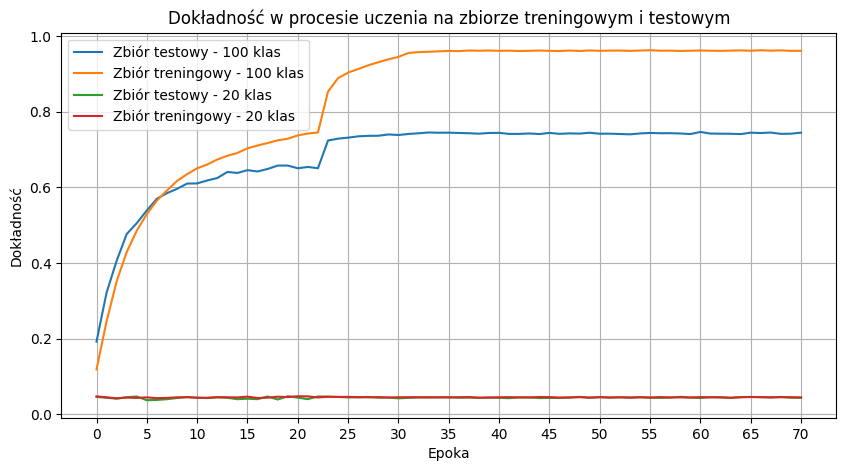

In [30]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:71],label="Zbiór testowy - 100 klas")
plt.plot(train_acc[:71],label="Zbiór treningowy - 100 klas")
plt.plot(test_acc_coarse[:71],label="Zbiór testowy - 20 klas")
plt.plot(train_acc_coarse[:71], label="Zbiór treningowy - 20 klas")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,71,5))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss01_accuracyplot.png')
plt.show()

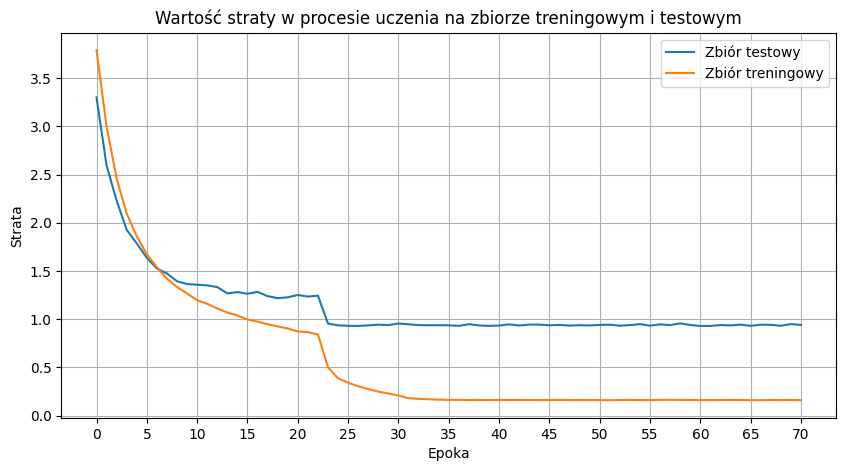

In [32]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:71],label="Zbiór testowy")
plt.plot(train_loss[:71],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,71,5))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss1_lossplot.png')
plt.show()

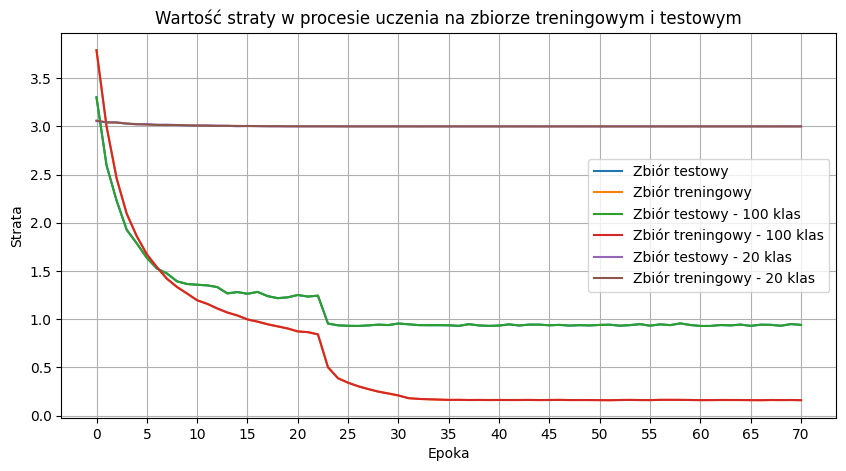

In [31]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:71],label="Zbiór testowy")
plt.plot(train_loss[:71],label="Zbiór treningowy")
plt.plot(test_loss_I[:71],label="Zbiór testowy - 100 klas")
plt.plot(train_loss_I[:71],label="Zbiór treningowy - 100 klas")
plt.plot(test_loss_II[:71],label="Zbiór testowy - 20 klas")
plt.plot(train_loss_II[:71],label="Zbiór treningowy - 20 klas")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,71,5))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss1all_lossplot.png')
plt.show()

## Confusion matrix

In [40]:
model.eval()
correct_test, total_test= 0, 0
correct_test_coarse, total_test_coarse = 0, 0
all_preds = []
all_labels = []
all_preds_coarse = []
all_labels_coarse = []
with torch.no_grad():
    for (inputs, targets, targets_coarse) in test_dl_20:
        inputs, targets, targets_coarse = inputs.to(device), targets.to(device), targets_coarse.to(device)
        logits1, logits2  = model(inputs)
        
        _, predicted = logits1.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        _, predicted_coarse = logits2.max(1)
        correct_test_coarse += predicted_coarse.eq(targets_coarse).sum().item()
        total_test_coarse += targets_coarse.size(0)
        all_preds_coarse.extend(predicted_coarse.cpu().numpy())
        all_labels_coarse.extend(targets_coarse.cpu().numpy())
        

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
accuracy_test_coarse = correct_test_coarse / total_test_coarse
accuracy_test_coarse_prc=accuracy_test_coarse*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f}%, Accuracy on coarse test data: {accuracy_test_coarse_prc:.2f}%')

Accuracy on test data: 74.97%, Accuracy on coarse test data: 4.45%


In [36]:
all_preds_superclasses=[]
for i in range(len(all_preds)):
    all_preds_superclasses.append(train_data_20.fine_to_coarse[all_preds[i]])

all_labels_superclasses=[]
for i in range(len(all_preds)):
    all_labels_superclasses.append(train_data_20.fine_to_coarse[all_labels[i]])
    
cm=confusion_matrix(all_labels_superclasses,all_preds_superclasses)

In [37]:
cm_coarse = confusion_matrix(all_labels_coarse, all_preds_coarse)

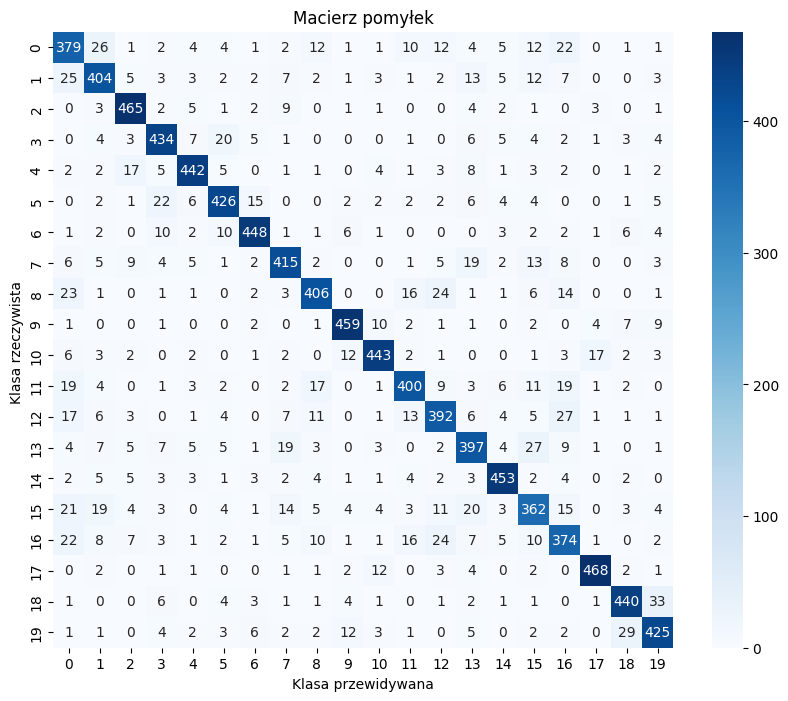

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('cm100_loss1.png')
plt.show()

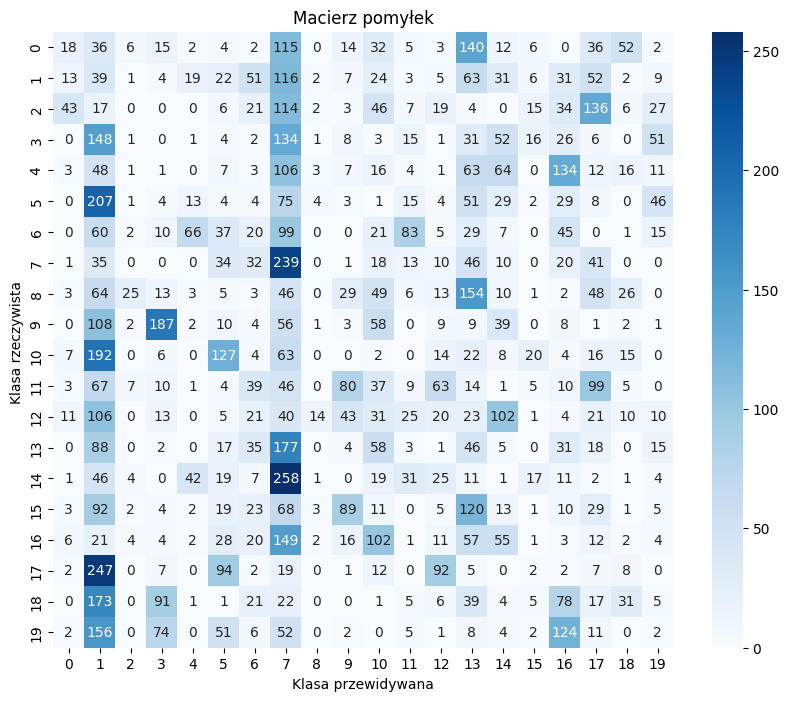

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_coarse, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('cm20_loss1.png')
plt.show()

# Train for 100 classes

In [48]:
saved_model_path='/kaggle/input/loss-double-models/cifar100_20classes_ep45A0.pth'

In [49]:
model_test=DoubleResNet18()
checkpoint = torch.load(saved_model_path)
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [50]:
model_test.to(device)

DoubleResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      

In [51]:
model_test.eval()
correct_test, total_test= 0, 0
correct_test_coarse, total_test_coarse = 0, 0
all_preds = []
all_labels = []
all_preds_coarse = []
all_labels_coarse = []
with torch.no_grad():
    for (inputs, targets, targets_coarse) in test_dl_20:
        inputs, targets, targets_coarse = inputs.to(device), targets.to(device), targets_coarse.to(device)
        logits1, logits2  = model_test(inputs)
        
        _, predicted = logits1.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        _, predicted_coarse = logits2.max(1)
        correct_test_coarse += predicted_coarse.eq(targets_coarse).sum().item()
        total_test_coarse += targets_coarse.size(0)
        all_preds_coarse.extend(predicted_coarse.cpu().numpy())
        all_labels_coarse.extend(targets_coarse.cpu().numpy())
        

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
accuracy_test_coarse = correct_test_coarse / total_test_coarse
accuracy_test_coarse_prc=accuracy_test_coarse*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f}%, Accuracy on coarse test data: {accuracy_test_coarse_prc:.2f}%')

Accuracy on test data: 0.80%, Accuracy on coarse test data: 84.35%


In [ ]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
alpha=0.5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    data_loader = tqdm(train_dl, total=len(train_dl), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets,targets_coarse) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        logits1, logits2 = model(input)
        loss_I = criterion_I(logits1, targets)
        loss_II=criterion_II(logits2, targets_coarse)
        loss=(alpha)*loss_I+(1-alpha)*loss_II
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), accuracy=correct_predictions / total_samples)

    average_loss = total_loss / len(train_dl)
    accuracy = correct_predictions / total_samples

    train_loss.append(average_loss)
    train_acc.append(accuracy)
    
    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    with torch.no_grad():
        for (inputs, targets, targets_coarse) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_I = criterion_I(outputs, targets)
            loss_II=criterion_II(outputs, targets_coarse)
            loss=(alpha)*loss_I+(1-alpha)*loss_II
            total_loss_test += loss.item()

            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)

        accuracy_test = correct_test / total_test
        average_loss_test = total_loss_test / len(test_dl)
   
    test_loss.append(average_loss_test)
    test_acc.append(accuracy_test)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%, Loss on test data: {average_loss_test:.4f} Accuracy on test data: {100 * accuracy_test:.2f} %')


#     if epoch%5==0:
#         model_save_path = '/kaggle/working/resnet_cifar100_100classes_e' + str(epoch+1) + '.pth'
#         training_stats = {
#           'epoch': epoch+1,
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'scheduler_state_dict': scheduler.state_dict(),
#           'loss': average_loss,
#           'accuracy': accuracy,
#           'test_accuracy': accuracy_test,
#           'test_loss': average_loss_test,
#           'learning_rate': optimizer.param_groups[0]["lr"]
#         }
    model_save_path = '/kaggle/working/resnet_cifar100_100classes_e' + str(epoch+1) + '.pth'
    training_stats = {
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'loss': average_loss,
      'accuracy': accuracy,
      'test_accuracy': accuracy_test,
      'test_loss': average_loss_test,
      'learning_rate': optimizer.param_groups[0]["lr"]
    }
    scheduler.step()
    torch.save(training_stats, model_save_path)

In [ ]:
model_save_path = '/kaggle/working/resnet_cifar100_' + str(87) + '.pth'
training_stats = {
  'epoch': epoch+1,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'scheduler_state_dict': scheduler.state_dict(),
  'loss': average_loss,
  'accuracy': accuracy,
  'test_accuracy': accuracy_test,
  'test_loss': average_loss_test,
  'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)